# DRL Exercise 3: Meta and Transfer Learning

Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

As we have seen in previous exercises, deep reinforcement learning algorithms usually require a large number of trials, and learning a new task entails recollecting a large dataset and training from scratch.

Intuitively, knowledge gained in learning one task should help in learning new, related tasks more quickly, similarly to how humans and animals work. In this assignment, we design reinforcement learning algorithms that do exactly that. These types of algorithms are called meta- or transfer-learning algorithms.

## Section 1: Training Individual Networks

In this section, we will implement the actor-critic algorithm from exercise 2 but using two additional environments: Acrobot and MountainCarContinuous. Our goal is to achieve the environments' goals: bringing the acrobot to a pre-specified height and reaching the top of the mountain, respectively.

Similar to exercise 2, we decided to look at two different metrics to measure the performance of the algorithm: **convergence** and **optimal performance**. We defined the convergence of the algorithm to be when for the past 100 episodes, it reaches a rolling average over the past 100 episodes of the convergence threshold. We decided on an optimal performance threshold of a rolling average, which indicates that the algorithm has reached a state where it is mostly getting perfect scores in the game. Both of these thresholds are different for different environments.

In CartPole, the convergence threshold was 195 and the optimal performance threshold was 475. In Acrobot, the convergence threshold was -200 and the optimal performance threshold was -100. In MountainCarContinuous, the convergence threshold was 50 and the optimal performance threshold was 90.


To make the transfer learning task later on easier, the size of the input and output for all tasks is identical. After adding in the general state padding and the action masking for the additional discrete environment, Acrobot, we also added in the ability for the algorithm to handle continuous environments like the required MountainCarContinuous.

Handling the continuous case proved to be more complicated than that of the discrete case, and we changed the architecture of the networks slightly as well as added in state scaling in order for the agent to perform better.

In the discrete environments, both CartPole and Acrobot, we used the same policy and value network architectures as we did in the previous exercise. Both networks contain a hidden layer of size 128 with a ReLU activation function.

In [ ]:
!pip install gymnasium
!pip install torch torchvision

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_action_space_size(env):
    if isinstance(env.action_space, gym.spaces.Box):
        return env.action_space.shape[0]
    else:
        return env.action_space.n

In [ ]:
def init_weights(layer, gain=1.0):
    if isinstance(layer, nn.Linear):
        torch.nn.init.orthogonal_(layer.weight, gain=gain)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

In [ ]:
def create_scaler(env, n_samples=10000):
    states = []
    for _ in range(n_samples):
        s = env.observation_space.sample()
        states.append(s)
    states = np.array(states)

    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(states)
    return scaler

In [ ]:
def scale_state(state, scaler):
    scaled = scaler.transform(state.reshape(1, -1))
    # return as 1D
    return scaled[0]

In [ ]:
def pad_state(state, max_input_size):
    padded_state = np.zeros(max_input_size)
    padded_state[: len(state)] = state

    return padded_state

In [ ]:
def mask_action(action_probs, act_space):
    masked_probs = action_probs.clone()
    masked_probs[act_space:] = 0
    masked_probs /= masked_probs.sum()

    return masked_probs

In [ ]:
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, target_average):
    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        print(f"Agent reached optimal performance with an average reward of {target_average} over 100 episodes at episode {episode + 1}")

    return rolling_avg

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class PolicyNetworkContinuous(nn.Module):
    def __init__(self, input_size, output_size, hidden_size1=40, hidden_size2=40):
        super(PolicyNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ELU(),
        )
        self.mu_layer = nn.Linear(hidden_size2, output_size)
        self.log_std = nn.Parameter(torch.zeros(output_size))

        self.apply(init_weights)

    def forward(self, x):
        x = self.fc(x)
        mu = self.mu_layer(x)
        log_std = self.log_std.clamp(-2, 1)
        std = torch.exp(log_std)
        return mu, std

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class ValueNetworkContinuous(nn.Module):
    def __init__(self, input_size, hidden_size1=400, hidden_size2=400):
        super(ValueNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ELU(),
            nn.Linear(hidden_size2, 1)
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.fc(x)

In [ ]:
def actor_critic(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size,
                 num_episodes=1000, gamma=0.99, convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()

        if isinstance(env.action_space, gym.spaces.Box):
            scaler = create_scaler(env)
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            action_probs = policy_network(state_tensor)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum()  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards

In [ ]:
envs = {
    "CartPole-v1": gym.make("CartPole-v1"),
    "Acrobot-v1": gym.make("Acrobot-v1"),
    "MountainCarContinuous-v0": gym.make("MountainCarContinuous-v0")
}

env_targets = {
    "CartPole-v1": {"optimal": 475, "convergence": 195, "lr_p": 0.0002171250228971598, "lr_v": 0.0006, "gamma": 0.9915614564438548},
    "Acrobot-v1": {"optimal": -100, "convergence": -200, "lr_p": 0.0006403723092688441, "lr_v": 0.0008903908181162374, "gamma": 0.9936670420538545},
    "MountainCarContinuous-v0": {"optimal": 90, "convergence": 50, "lr_p": 3.7549879519576414e-05, "lr_v": 0.0005749550762716619, "gamma": 0.9971441494660566}
}

max_input_size = max(env.observation_space.shape[0] for env in envs.values())
max_output_size = max(env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n for env in envs.values())
print(max_input_size, max_output_size)

In [ ]:
env_name = "Acrobot-v1"
env = gym.make(env_name)

lr_p = env_targets[env_name]["lr_p"]
lr_v = env_targets[env_name]["lr_v"]
gamma = env_targets[env_name]["gamma"]

target_optimal = env_targets[env_name]["optimal"]
target_convergence = env_targets[env_name]["convergence"]
action_space_size = get_action_space_size(env)

if isinstance(env.action_space, gym.spaces.Box):
  policy_net = PolicyNetworkContinuous(max_input_size, max_output_size)
  value_net = ValueNetworkContinuous(max_input_size)
else:
  policy_net = PolicyNetwork(max_input_size, max_output_size)
  value_net = ValueNetwork(max_input_size)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net.parameters(), lr=lr_v)

print(f"Training on {env_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards = actor_critic(
    env, policy_net, value_net, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=2000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title(f"Rewards and Rolling Average Rewards in {env_name}")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title(f"Policy and Value Losses per Training Step in {env_name}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

**CartPole**

In the CartPole environment, we reached convergence after 1319 episodes and optimal performance after 1803. The total training time was 854.28 seconds. The hyperparameters used were:

* Policy network learning rate: 0.0009544834979814932
* Value network learning rate: 0.0001692152839618964
* Gamma: 0.9915614564438548


**Plot of Rewards**

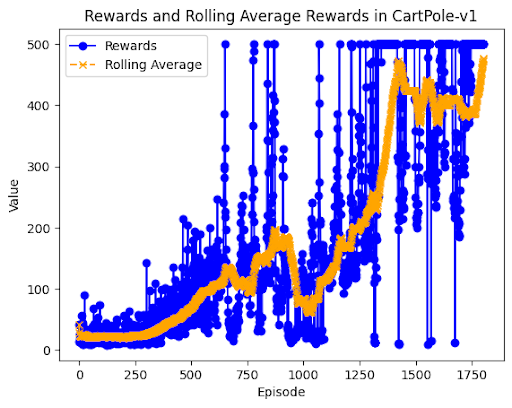

**Plot of Losses**

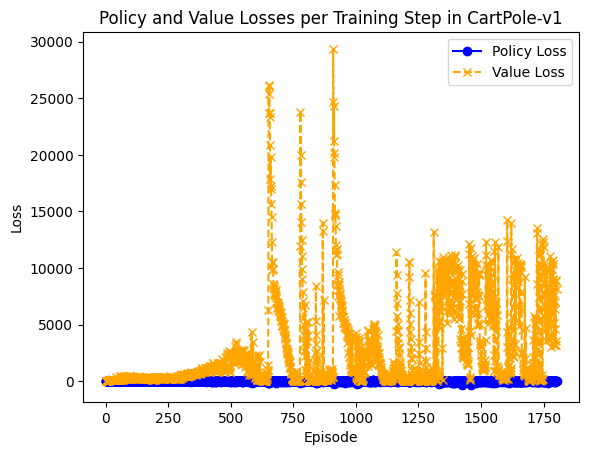

**Acrobot**

In the Acrobot environment, we reached convergence at episode 131 and optimal performance at episode 115. The total training time of the algorithm was 39.73 seconds. The hyperparameters we used were:

* Policy network learning rate: 0.0009544834979814932
* Value network learning rate: 0.0001692152839618964
* Gamma: 0.9937422659323847


**Plot of Rewards**

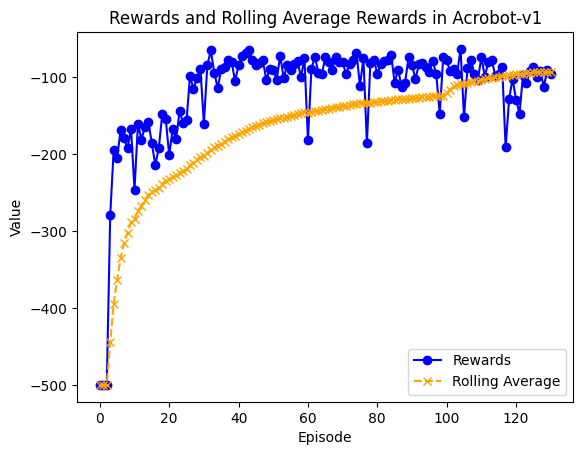

**Plot of Losses**

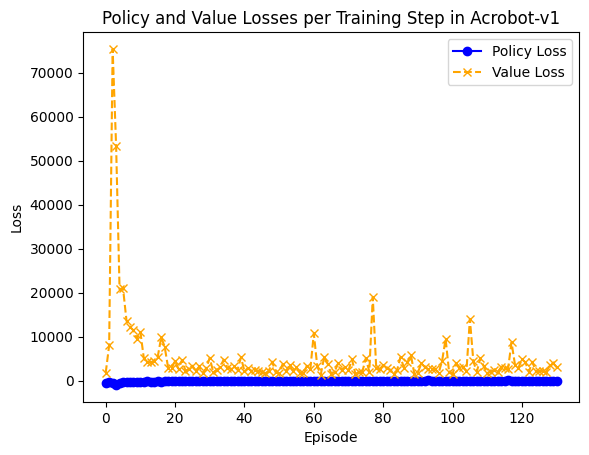

**MountainCarContinuous**

This environment was a bit more tricky to train, and after a lot of experimentation, we ended up changing the architecture of the actor and critic networks in order to help the agent perform better. Instead of the ReLU functions that we used in the discrete environments, we used ELU, and in both networks, we added an additional hidden layer. The size of the hidden layers in the policy network were 40 and in the value network were 400. These changes improved the performance of the algorithm drastically.

In the MountainCarContinuous environment, we reached convergence at episode 100 and optimal performance at episode 138. The total training time of the algorithm was 150.9 seconds. The hyperparameters we used were:

* Policy network learning rate: 3.7549879519576414e-05
* Value network learning rate: 0.0005749550762716619
* Gamma: 0.9971441494660566


**Plot of Rewards**

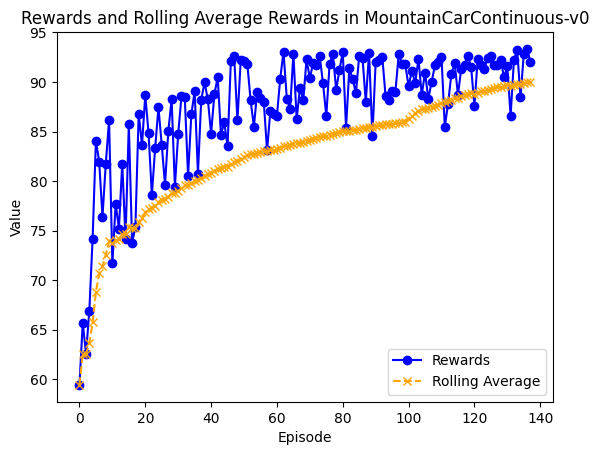

**Plot of Losses**

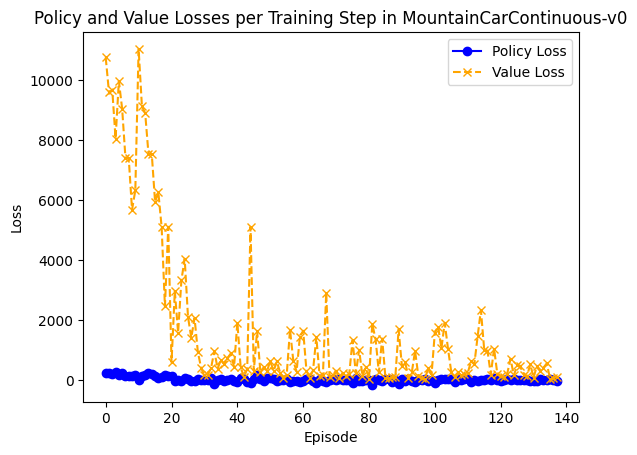

## Hyperparameter Tuning

In [ ]:
def random_hyperparameters():
    return {
        'gamma': random.uniform(0.99, 0.999),
        'learning_rate_policy': random.uniform(1e-4, 1e-3),
        'learning_rate_value': random.uniform(1e-4, 1e-3),
    }

In [ ]:
def actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size, num_episodes, gamma,
                        convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    convergence = False

    for episode in range(num_episodes):
        state = env.reset()
        max_position = -0.6

        if isinstance(env.action_space, gym.spaces.Box):
            scaler = create_scaler(env)
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            action_probs = policy_network(state_tensor)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum()   # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            state = next_state
            total_reward += reward

            max_position = max(max_position, state[0])

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    return np.mean(rewards_per_episode[-100:])

In [ ]:
envs = {
    "CartPole-v1": gym.make("CartPole-v1"),
    "Acrobot-v1": gym.make("Acrobot-v1"),
    "MountainCarContinuous-v0": gym.make("MountainCarContinuous-v0")
}

env_targets = {
    "CartPole-v1": {"optimal": 475, "convergence": 195, "lr_p": 0.0002171250228971598, "lr_v": 0.0006, "gamma": 0.9915614564438548},
    "Acrobot-v1": {"optimal": -100, "convergence": -200, "lr_p": 0.0006403723092688441, "lr_v": 0.0008903908181162374, "gamma": 0.9936670420538545},
    "MountainCarContinuous-v0": {"optimal": 90, "convergence": 50, "lr_p": 3.7549879519576414e-05, "lr_v": 0.0005749550762716619, "gamma": 0.9971441494660566}
}

max_input_size = max(env.observation_space.shape[0] for env in envs.values())
max_output_size = max(env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n for env in envs.values())

### Hyperparameter Tuning for CartPole

In [ ]:
env = gym.make("CartPole-v1")

best_hyperparams = None
best_performance = -float('inf')
num_trials = 20
target_optimal = env_targets["CartPole-v1"]["optimal"]
target_convergence = env_targets["CartPole-v1"]["convergence"]
action_space_size = get_action_space_size(env)


for trial in range(num_trials):
    params = random_hyperparameters()

    value_network = ValueNetwork(max_input_size)
    policy_network = PolicyNetwork(max_input_size, max_output_size)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params['learning_rate_policy'])
    value_optimizer = optim.Adam(value_network.parameters(), lr=params['learning_rate_value'])

    print(f"Trial {trial + 1}: {params}")

    avg_reward = actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, action_space_size,
                                     max_input_size, num_episodes=1000, gamma=params['gamma'], convergence_threshold=target_convergence,
                                     optimal_performance_threshold=target_optimal)

    print(f"Avg Reward: {avg_reward}")

    if avg_reward > best_performance:
        best_performance = avg_reward
        best_hyperparams = params

print("\nBest Hyperparameters for CartPole:")
print(best_hyperparams)
print(f"Best Performance for CartPole: {best_performance}")

### Hyperparameter Tuning for Acrobot

In [ ]:
env = gym.make("Acrobot-v1")

best_hyperparams = None
best_performance = -float('inf')
num_trials = 20
target_optimal = env_targets["Acrobot-v1"]["optimal"]
target_convergence = env_targets["Acrobot-v1"]["convergence"]
action_space_size = get_action_space_size(env)


for trial in range(num_trials):
    params = random_hyperparameters()

    value_network = ValueNetwork(max_input_size)
    policy_network = PolicyNetwork(max_input_size, max_output_size)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params['learning_rate_policy'])
    value_optimizer = optim.Adam(value_network.parameters(), lr=params['learning_rate_value'])

    print(f"Trial {trial + 1}: {params}")

    avg_reward = actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, action_space_size,
                                     max_input_size, num_episodes=1000, gamma=params['gamma'], convergence_threshold=target_convergence,
                                     optimal_performance_threshold=target_optimal)

    print(f"Avg Reward: {avg_reward}")

    if avg_reward > best_performance:
        best_performance = avg_reward
        best_hyperparams = params

print("\nBest Hyperparameters for Acrobot:")
print(best_hyperparams)
print(f"Best Performance for Acrobot: {best_performance}")

### Hyperparameter Tuning for MountainCar

In [ ]:
env = gym.make("MountainCarContinuous-v0")

best_hyperparams = None
best_performance = -float('inf')
num_trials = 20
target_optimal = env_targets["MountainCarContinuous-v0"]["optimal"]
target_convergence = env_targets["MountainCarContinuous-v0"]["convergence"]
action_space_size = get_action_space_size(env)


for trial in range(num_trials):
    params = random_hyperparameters()

    value_network = ValueNetworkContinuous(max_input_size)
    policy_network = PolicyNetworkContinuous(max_input_size, max_output_size)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params['learning_rate_policy'])
    value_optimizer = optim.Adam(value_network.parameters(), lr=params['learning_rate_value'])

    print(f"Trial {trial + 1}: {params}")

    avg_reward = actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, action_space_size,
                                     max_input_size, num_episodes=1000, gamma=params['gamma'], convergence_threshold=target_convergence,
                                     optimal_performance_threshold=target_optimal)

    print(f"Avg Reward: {avg_reward}")

    if avg_reward > best_performance:
        best_performance = avg_reward
        best_hyperparams = params

print("\nBest Hyperparameters for MountainCar:")
print(best_hyperparams)
print(f"Best Performance for MountainCar: {best_performance}")

## Discussion

We realized that we needed to have different architectures for discrete and continuous environments because of the nature of the environment itself. In order for the model to be able to sample an action from the continuous environment, it had to build the proper distribution and thus would need to return the mean and standard deviation as opposed to the action probabilities in the discrete case.

At first, we kept the rest of the architecture the same as in the discrete case, simply changing the outputs for the continuous case. However, we soon realized that this architecture did not serve us well enough and the model did not learn, never reaching convergence. When we changed the architecture as mentioned above, the network was able to learn instantly more quickly and much better.

Even after hyperparameter tuning, the CartPole environment was the hardest for the agent to learn, taking the most time to train at 854 seconds. Perhaps a different architecture would have worked better for this environment, similarly to how the change in architecture benefited the MountainCarContinuous environment. In addition, it is easy to see the quick convergence of the agent in both the Acrobot and MountainCarContinuous environments in the rewards and losses graphs, whereas the graphs for the CartPole environment are less smooth and the value network does not look like it converges at all.
